In [1]:
import os
import numpy as np 
import pandas as pd
import time 

import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from utils.helper import split_scale_dataset

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load data
combined_df = pd.read_csv("datasets/combined_data.csv", index_col=0, parse_dates=True)

Split and scale datasets.

In [5]:
train, vali, test = split_scale_dataset(combined_df, train_split=0.7, test_split=0.15, scaler_type='minmax2')

29136 observations in the train dataset.
6240 observations in the validation dataset. 
6240 observations in the test dataset.


In [7]:
train.describe().round(2)

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
count,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00
mean,2.72,0.70,1.28,1.64,1.18,3.06,0.65,1.65,1.57,1.57,2.35,1.22,1.61,1.90,0.80,1.02,2.31,0.99,1.51
std,1.09,1.09,1.00,1.18,1.00,0.71,1.00,1.04,1.07,1.00,0.99,1.45,0.94,0.93,1.12,0.88,1.06,1.38,1.10
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.80,0.00,0.50,0.56,0.43,2.51,0.00,0.78,0.66,0.74,1.50,0.05,0.87,1.20,0.00,0.40,1.39,0.00,0.59
50%,2.68,0.02,1.00,1.52,0.89,3.13,0.03,1.47,1.37,1.40,2.39,0.51,1.43,1.77,0.10,0.74,2.23,0.03,1.25
75%,3.69,1.09,1.78,2.57,1.64,3.57,1.03,2.39,2.35,2.28,3.13,2.20,2.17,2.57,1.48,1.36,3.22,1.89,2.21
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00


# 1. Persistence/ naive forecast

Last 24, 96, 168 hours as "predictions".

In [8]:
# Dictionary to rename columns
rename_col_dict = {
    'load_actual_entsoe_transparency': 'load',
    'solar_generation_actual': 'solar',
    'wind_generation_actual': 'wind',
    'wind_onshore_generation_actual': 'wind_onshore',
    'wind_offshore_generation_actual': 'wind_offshore'
}

# List to store metrics for the DataFrame
data = []

# Loop over each prediction length
for pred_len in [24, 96, 168]:
    
    # Combine the last `pred_len` hours of validation data with test data
    forecast_df = pd.concat([vali.iloc[-pred_len:], test], axis=0)

    # Shift the DataFrame by `pred_len` hours to create the persistence forecast
    forecast_df = forecast_df.shift(freq=f'{pred_len}H')

    # Cut off the last hours, because they are longer by 'window_len' than the test data
    forecast_df = forecast_df.iloc[:-pred_len]

    # Loop over each country
    for country in ['DE', 'GB', 'ES', 'FR', 'IT']:

        # Choose columns that belong to the current country
        country_columns = [col for col in test.columns if col.startswith(country)]

        # Loop over each column in the current country
        for col in country_columns:

            # Rename the column based on the country
            if country == 'GB':
                new_col = rename_col_dict.get(col.split('_', 2)[-1], col)
            else:
                new_col = rename_col_dict.get(col.split('_', 1)[-1], col)

            # Calculate metrics
            mae = mean_absolute_error(test[col], forecast_df[col])
            mse = mean_squared_error(test[col], forecast_df[col])
            rmse = np.sqrt(mse)

            # Append metrics to the list
            data.append({
                'Country': country,
                'Pred_len': pred_len,
                'Column': new_col,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse
            })

# Convert the list of dictionaries into a DataFrame
df_persistence = pd.DataFrame(data)

# Set MultiIndex
df_persistence.set_index(['Country', 'Pred_len', 'Column'], inplace=True)

df_persistence = df_persistence.sort_index().round(4)
df_persistence

MAE     MSE    RMSE
Country Pred_len Column                               
DE      24       load           0.4346  0.4406  0.6638
                 solar          0.2164  0.2008  0.4481
                 wind           0.7520  1.0466  1.0230
                 wind_offshore  1.3587  3.1817  1.7837
                 wind_onshore   0.7067  0.9706  0.9852
        96       load           0.8071  1.0468  1.0231
                 solar          0.3203  0.4056  0.6368
                 wind           1.0824  1.9492  1.3961
                 wind_offshore  1.7051  4.5559  2.1345
                 wind_onshore   1.0082  1.8061  1.3439
        168      load           0.2107  0.1212  0.3481
                 solar          0.3540  0.4718  0.6869
                 wind           1.0601  1.9788  1.4067
                 wind_offshore  1.6241  4.1706  2.0422
                 wind_onshore   1.0035  1.8611  1.3642
ES      24       load           0.3302  0.2624  0.5122
                 solar          0.3877  0.4936  0.7026
                 wind_onshore   0.6977  0.8002  0.8945
        96       load           0.6007  0.6181  0.7862
                 solar          0.5405  0.9090  0.9534
                 wind_onshore   0.9467  1.4658  1.2107
        168      load           0.2435  0.1090  0.3302
                 solar          0.6065  1.1289  1.0625
                 wind_onshore   1.0069  1.6082  1.2682
FR      24       load           0.2078  0.1135  0.3369
                 solar          0.2159  0.1898  0.4357
                 wind_onshore   0.7795  1.2099  1.0999
        96       load           0.3983  0.2797  0.5289
                 solar          0.3360  0.4157  0.6447
                 wind_onshore   1.1441  2.3256  1.5250
        168      load           0.2162  0.1274  0.3570
                 solar          0.3549  0.4772  0.6908
                 wind_onshore   1.0526  2.0498  1.4317
GB      24       load           0.1903  0.0783  0.2798
                 solar          0.2516  0.2517  0.5017
                 wind           0.9951  1.7157  1.3099
                 wind_offshore  1.3784  3.3611  1.8333
                 wind_onshore   0.7969  1.0989  1.0483
        96       load           0.2808  0.1424  0.3774
                 solar          0.3354  0.4331  0.6581
                 wind           1.3617  2.9024  1.7037
                 wind_offshore  1.8117  5.2959  2.3013
                 wind_onshore   1.0650  1.8096  1.3452
        168      load           0.1986  0.0761  0.2758
                 solar          0.3706  0.5037  0.7097
                 wind           1.2982  2.6874  1.6393
                 wind_offshore  1.7716  5.1337  2.2658
                 wind_onshore   1.0005  1.6433  1.2819
IT      24       load           0.3878  0.3873  0.6224
                 solar          0.1856  0.1522  0.3901
                 wind_onshore   0.8758  1.3162  1.1472
        96       load           0.7216  0.9185  0.9584
                 solar          0.2478  0.2715  0.5210
                 wind_onshore   1.1452  2.1811  1.4768
        168      load           0.2527  0.1454  0.3813
                 solar          0.2659  0.2897  0.5383
                 wind_onshore   1.1190  2.0540  1.4332

In [9]:
# Group by country and window length
df_persistence_country = df_persistence.groupby(['Country', 'Pred_len']).mean()
df_persistence_country.columns = pd.MultiIndex.from_product([['Persistence'], ['MSE', 'MAE', 'RMSE']], names=['Model', 'Metrics'])
df_persistence_country.round(4)

Model            Persistence                
Metrics                  MSE     MAE    RMSE
Country Pred_len                            
DE      24            0.6937  1.1681  0.9808
        96            0.9846  1.9527  1.3069
        168           0.8505  1.7207  1.1696
ES      24            0.4719  0.5187  0.7031
        96            0.6960  0.9976  0.9834
        168           0.6190  0.9487  0.8870
FR      24            0.4011  0.5044  0.6242
        96            0.6261  1.0070  0.8995
        168           0.5412  0.8848  0.8265
GB      24            0.7225  1.3011  0.9946
        96            0.9709  2.1167  1.2771
        168           0.9279  2.0088  1.2345
IT      24            0.4831  0.6186  0.7199
        96            0.7049  1.1237  0.9854
        168           0.5459  0.8297  0.7843

In [10]:
# Create a folder named "results" if it doesn't exist
folder_name = "results"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

subfolder_name = os.path.join(folder_name, "naive")
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)

# Store dataframes
df_persistence.to_csv('results/naive/metrics_persistence_columns.csv')
df_persistence_country.to_csv('results/naive/metrics_persistence_countries.csv')

# 2. ARIMA model

1. AutoArima from pmdarima package finds optimal parameters for ARIMA model automatically.

2. However, according description, it is better to set seasonal parameter that we determined from the data(m is for seasonality).

I performed small tests on load and solar columns with m=24 and without. Without m I got bad results, with m=24 - good results. As we saw, we have seasonality in these columns (based on the visual inspection in the 1.Data_analysis notebook as well.)  

Wind generation does not react on m parameter and therefore gives the worst performance among all columns. Since it has no short-term seasonality, it is harder to predict these values on hourly data. Of course, wind is supposed to be stronger during coldest periods of the year. But then we have to put to our model factor * 8760 observations. (24 hours * 365 days)

3. Additionally to that I performed ARIMA (or SARIMA) to find optimal input length for training the model.
Putting 576 data points (24 days) and 2160 (90 days, around 3 months) the latest improved average MSE from 0.34 up to 0.3 (based on 36 models). That means that our data has also some monthly seasonality.

4. Putting exogenous variables like 'HourOfDay' and 'DayOfWeek' detariorates performance. Therefore we use exclusively one time serie as the input.

In [ ]:
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html
# maxiter set btw 10-20, default=50 -> good trade off btw speed and robustness

In [11]:
# Create a folder named "results" if it doesn't exist
folder_name = "results"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

subfolder_name = os.path.join(folder_name, "arima")
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)

The problem is that training time of ARIMA model with parameter selection is long, especially for seasonal ARIMA. 
Unfortuntely, auto_arima has no GPU support.
We have 19 columns and each has 260 test days. Therefore, it is 4940 potential models.

In [12]:
int(test.__len__()/24 * test.columns.__len__())

4940

I performed ARIMA without exogenous variables on 12 days. So, 12 models for each of 19 columns. Only for load and solar columns seasonal ARIMA was performed. From output we can see that seasonal ARIMA on 12 models took between 70 and 115 minutes. 

Non-seasonal ARIMA on 12 models for all wind columns took around 1 min. The total time for 12*19=228 models is 800 minutes that is more than 13 hours.

In [13]:
start = time.time()

# Define parameters for ARIMA model (30 days)
input_len = 720     #(30 days)
n_models = 12        # number of models trained for each column
counter = 0         # to count number of all models


# List to collect metrics and predictions
arima_data = []

# Loop over each country
for country in ['DE', 'GB', 'ES', 'FR', 'IT']:
    # Loop over each prediction length
    for pred_len in [24, 96, 168]:
        # Loop over each column
        for col in [c for c in train.columns if c.startswith(country)]:
            
            # Determine seasonal parameters based on column content
            if any(prefix in col for prefix in ['load', 'solar']):
                seasonal = True
                m = 24
            elif any(prefix in col for prefix in ['wind']):
                seasonal = False
                m = 1
            
            print(f"Processing column: '{col}' with prediction length: {pred_len}")

            # Choose the last `input_len` hours of validation data for training
            tr_data = vali.iloc[-input_len:][col]

            # Extract true values for the column for the next `pred_len` hours
            true_values = test.iloc[:pred_len*n_models][col]

            rows_list = []

            int_start = time.time()

            # Forecast pred_len hours over n_models separately
            for i in range(n_models):
                idx_start = i * pred_len
                idx_end = (i + 1) * pred_len

                # Select the segment to forecast
                ts_data = test.iloc[idx_start:idx_end][col]

                # Fit the ARIMA model
                model = auto_arima(tr_data, stepwise=True, seasonal=seasonal, m=m, maxiter=10)
                print(f"Best ARIMA parameters: {model.order} {model.seasonal_order}")

                # Predict the next `pred_len` hours
                forecasts, confidence = model.predict(n_periods=pred_len, return_conf_int=True)

                # Append the last actual data to the training data
                tr_data = pd.concat([tr_data, ts_data], axis=0)

                # Limit training data to the last `input_len` hours
                tr_data = tr_data[-input_len:]

                # Calculate metrics
                mae = mean_absolute_error(ts_data, forecasts)
                mse = mean_squared_error(ts_data, forecasts)
                rmse = np.sqrt(mse)

                print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

                # Store metrics and predictions
                rows_list.append({"MAE": mae, "MSE": mse, "RMSE": rmse})
                counter += 1

            int_end = time.time()
            hours_int, rem_int = divmod(int_end - int_start, 3600)
            mins, secs = divmod(rem_int, 60)

            print(f"Time for {counter} models:", "{:0>2}h:{:0>2}m:{:05.2f}s".format(int(hours_int), int(mins), secs))
            print('-'*75)

            # Rename the column based on the country
            if country == 'GB':
                new_col = rename_col_dict.get(col.split('_', 2)[-1], col)
            else:
                new_col = rename_col_dict.get(col.split('_', 1)[-1], col)
                
            # Collect metrics
            arima_data.append((country, pred_len, new_col, 
                               mean_absolute_error(ts_data, forecasts),
                               mean_squared_error(ts_data, forecasts),
                               np.sqrt(mean_squared_error(ts_data, forecasts))))

end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
print("Total time:", "{:0>2}h:{:0>2}m:{:05.2f}s".format(int(hours), int(minutes), seconds))

Processing column: 'DE_load_actual_entsoe_transparency' with prediction length: 24
Best ARIMA parameters: (1, 1, 4) (2, 0, 2, 24)
MAE: 0.20, MSE: 0.06, RMSE: 0.25
Best ARIMA parameters: (2, 1, 2) (1, 0, 2, 24)
MAE: 0.16, MSE: 0.04, RMSE: 0.19
Best ARIMA parameters: (2, 1, 2) (2, 0, 2, 24)
MAE: 0.09, MSE: 0.01, RMSE: 0.11
Best ARIMA parameters: (2, 1, 2) (2, 0, 2, 24)
MAE: 0.14, MSE: 0.03, RMSE: 0.16
Best ARIMA parameters: (5, 1, 2) (2, 0, 2, 24)
MAE: 0.81, MSE: 0.79, RMSE: 0.89
Best ARIMA parameters: (0, 1, 3) (2, 0, 2, 24)
MAE: 0.31, MSE: 0.16, RMSE: 0.40
Best ARIMA parameters: (2, 1, 2) (2, 0, 2, 24)
MAE: 1.11, MSE: 1.51, RMSE: 1.23
Best ARIMA parameters: (0, 1, 5) (2, 0, 2, 24)
MAE: 0.17, MSE: 0.05, RMSE: 0.22
Best ARIMA parameters: (2, 1, 2) (2, 0, 2, 24)
MAE: 0.22, MSE: 0.07, RMSE: 0.27
Best ARIMA parameters: (4, 1, 2) (2, 0, 2, 24)
MAE: 0.18, MSE: 0.05, RMSE: 0.21
Best ARIMA parameters: (0, 1, 2) (2, 0, 2, 24)
MAE: 0.13, MSE: 0.02, RMSE: 0.15
Best ARIMA parameters: (0, 1, 3) (2, 

In [14]:
# Convert collected data into DataFrames
arima_df = pd.DataFrame(arima_data, columns=['Country', 'Pred_len', 'Column', 'MAE', 'MSE', 'RMSE'])
arima_df.set_index(['Country', 'Pred_len', 'Column'], inplace=True)
arima_df.round(4)

MAE     MSE    RMSE
Country Pred_len Column                               
DE      24       load           0.5781  0.4446  0.6668
                 solar          0.0801  0.0184  0.1357
                 wind           0.2366  0.0647  0.2543
                 wind_offshore  0.4713  0.2904  0.5389
                 wind_onshore   0.2242  0.0695  0.2636
        96       load           0.5708  0.4660  0.6826
                 solar          0.2185  0.1629  0.4036
                 wind           1.1300  1.7497  1.3228
                 wind_offshore  0.8568  0.9322  0.9655
                 wind_onshore   1.0750  1.6588  1.2879
        168      load           0.6116  0.7006  0.8370
                 solar          0.5997  0.6014  0.7755
                 wind           0.7718  0.7941  0.8911
                 wind_offshore  1.1901  2.1414  1.4634
                 wind_onshore   0.5997  0.6330  0.7956
GB      24       load           0.2135  0.0730  0.2702
                 solar          0.0661  0.0052  0.0721
                 wind           1.0721  1.4607  1.2086
                 wind_offshore  1.3121  2.3256  1.5250
                 wind_onshore   0.6415  0.5281  0.7267
        96       load           0.3158  0.1803  0.4246
                 solar          0.4220  0.4800  0.6929
                 wind           1.7027  3.6107  1.9002
                 wind_offshore  1.5430  2.6436  1.6259
                 wind_onshore   1.5923  3.2522  1.8034
        168      load           0.2555  0.1248  0.3532
                 solar          0.3168  0.3000  0.5477
                 wind           0.9721  1.2211  1.1050
                 wind_offshore  1.5211  2.8220  1.6799
                 wind_onshore   1.2720  2.5252  1.5891
ES      24       load           0.8605  0.9120  0.9550
                 solar          0.0840  0.0303  0.1741
                 wind_onshore   0.2074  0.0670  0.2588
        96       load           0.4088  0.3725  0.6103
                 solar          0.7192  1.3535  1.1634
                 wind_onshore   1.2200  1.8379  1.3557
        168      load           0.3320  0.1973  0.4442
                 solar          0.7002  1.0569  1.0281
                 wind_onshore   0.9243  1.2567  1.1210
FR      24       load           0.4679  0.2666  0.5163
                 solar          0.1041  0.0280  0.1674
                 wind_onshore   0.1162  0.0273  0.1653
        96       load           0.4153  0.2784  0.5276
                 solar          0.2473  0.1895  0.4353
                 wind_onshore   1.1021  1.6884  1.2994
        168      load           0.9226  1.1800  1.0863
                 solar          0.4402  0.4454  0.6674
                 wind_onshore   1.1822  1.9586  1.3995
IT      24       load           0.8299  0.9100  0.9540
                 solar          0.2366  0.1733  0.4163
                 wind_onshore   0.3768  0.2115  0.4599
        96       load           0.4370  0.3546  0.5955
                 solar          0.2594  0.2371  0.4870
                 wind_onshore   0.9738  1.4787  1.2160
        168      load           0.3210  0.1979  0.4449
                 solar          0.5745  0.8989  0.9481
                 wind_onshore   1.0988  1.9845  1.4087

In [90]:
# By country
arima_df_country = arima_df.groupby(['Country', 'Pred_len']).mean()
arima_df_country.columns = pd.MultiIndex.from_product([['(S)ARIMA'], ['MSE', 'MAE', 'RMSE']], names=['Model', 'Metrics'])
arima_df_country.round(4)

Model            (S)ARIMA                
Metrics               MSE     MAE    RMSE
Country Pred_len                         
DE      24         0.3180  0.1775  0.3719
        96         0.7702  0.9939  0.9325
        168        0.7546  0.9741  0.9525
ES      24         0.3840  0.3364  0.4626
        96         0.7826  1.1880  1.0432
        168        0.6522  0.8370  0.8644
FR      24         0.2294  0.1073  0.2830
        96         0.5882  0.7187  0.7541
        168        0.8484  1.1947  1.0511
GB      24         0.6611  0.8785  0.7605
        96         1.1152  2.0334  1.2894
        168        0.8675  1.3986  1.0550
IT      24         0.4811  0.4316  0.6100
        96         0.5567  0.6901  0.7662
        168        0.6647  1.0271  0.9339

In [55]:
# Store dataframes
arima_df.to_csv('results/arima/metrics_arima_columns.csv')
arima_df_country.to_csv('results/arima/metrics_arima_countries.csv')

In [91]:
arima_df_country.columns = arima_df_country.columns.droplevel('Model')
arima_df_country.reset_index(inplace=True)


In [93]:
arima_df_country

Metrics,Country,Pred_len,MSE,MAE,RMSE
0,DE,24,0.318047,0.177510,0.371851
1,DE,96,0.770241,0.993926,0.932496
2,DE,168,0.754590,0.974105,0.952523
3,ES,24,0.383959,0.336424,0.462646
4,ES,96,0.782619,1.187988,1.043150
5,ES,168,0.652184,0.836981,0.864435
6,FR,24,0.229406,0.107298,0.282981
7,FR,96,0.588218,0.718744,0.754089
8,FR,168,0.848372,1.194675,1.051054
9,GB,24,0.661066,0.878535,0.760519


In [96]:
df = arima_df_country.melt(id_vars=['Country', 'Pred_len'], var_name='Metric', value_name='Value')

,Country,Pred_len,Metric,Value
0,DE,24,MSE,0.318047
1,DE,96,MSE,0.770241
2,DE,168,MSE,0.754590
3,ES,24,MSE,0.383959
4,ES,96,MSE,0.782619
5,ES,168,MSE,0.652184
6,FR,24,MSE,0.229406
7,FR,96,MSE,0.588218
8,FR,168,MSE,0.848372
9,GB,24,MSE,0.661066


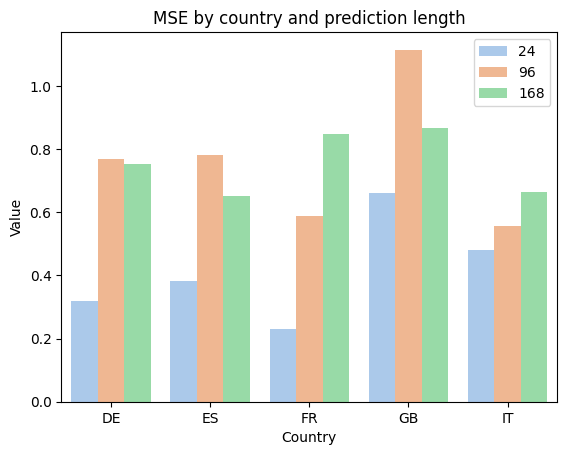

In [102]:
import seaborn as sns
import pandas as pd
df_mse = df[df['Metric'] == 'MSE']
# Create a bar plot with two datasets
#sns.barplot(x=['Country', 'Pred_len'], y='Value', hue='Metric', data=df, palette="pastel")
sns.barplot(x='Country', y='Value', hue='Pred_len', data=df_mse, palette="pastel")
# Add a legend
plt.legend()

# Set the title
plt.title("MSE by country and prediction length")
plt.show()

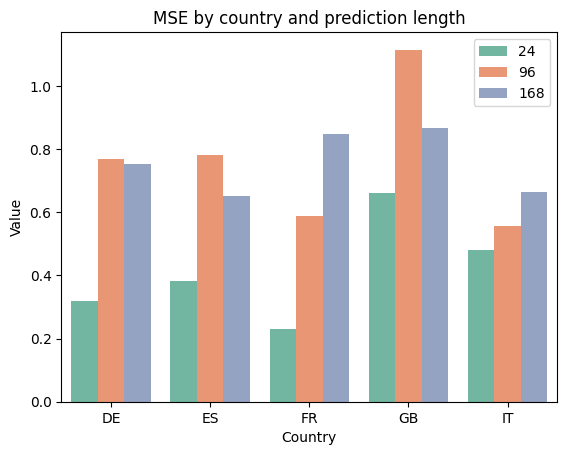

In [103]:
import seaborn as sns
import pandas as pd
df_mse = df[df['Metric'] == 'MSE']
# Create a bar plot with two datasets
#sns.barplot(x=['Country', 'Pred_len'], y='Value', hue='Metric', data=df, palette="pastel")
sns.barplot(x='Country', y='Value', hue='Pred_len', data=df_mse, palette="Set2")
# Add a legend
plt.legend()

# Set the title
plt.title("MSE by country and prediction length")
plt.show()

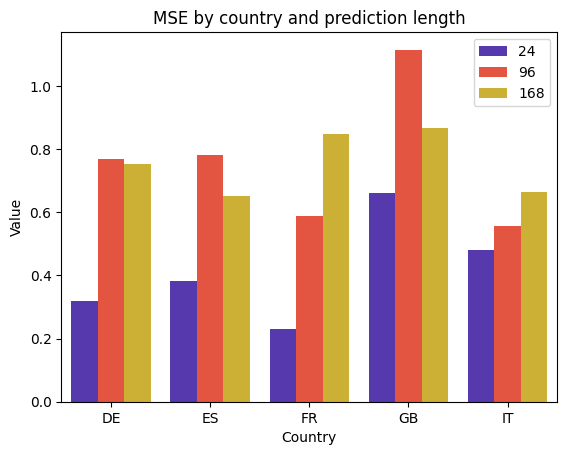

In [106]:
import seaborn as sns
import pandas as pd
df_mse = df[df['Metric'] == 'MSE']
# Create a bar plot with two datasets
#sns.barplot(x=['Country', 'Pred_len'], y='Value', hue='Metric', data=df, palette="pastel")
sns.barplot(x='Country', y='Value', hue='Pred_len', data=df_mse, palette="CMRmap")
# Add a legend
plt.legend()

# Set the title
plt.title("MSE by country and prediction length")
plt.show()

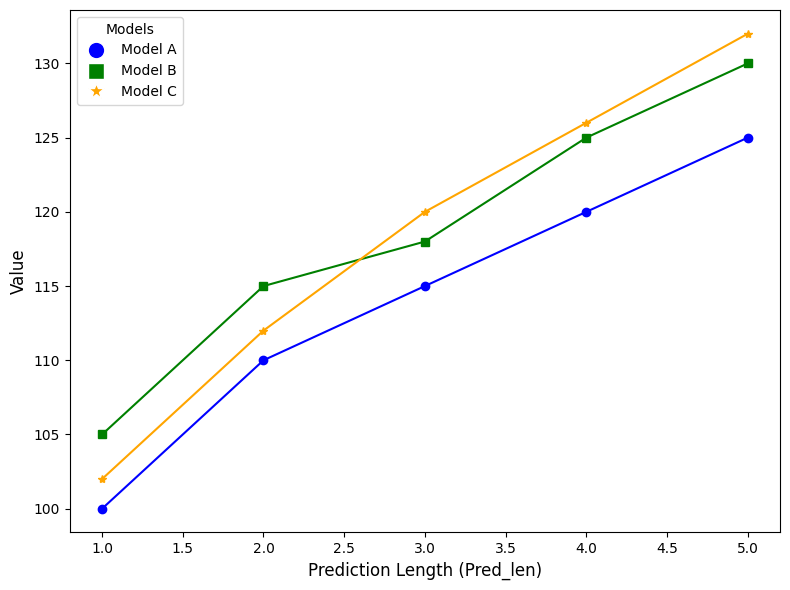

In [125]:
import matplotlib.pyplot as plt

# Example data
models = ['Model A', 'Model B', 'Model C']
pred_len = [1, 2, 3, 4, 5]  # x-axis: Prediction lengths
values = {
    'Model A': [100, 110, 115, 120, 125],  # y-axis values for Model A
    'Model B': [105, 115, 118, 125, 130],  # y-axis values for Model B
    'Model C': [102, 112, 120, 126, 132]   # y-axis values for Model C
}

# Define different markers and line styles
markers = ['o', 's', '*']  #'^' Circle, Square, Star markers
colors = ['blue', 'green', 'orange']  # Different colors for each model

fig, ax = plt.subplots(figsize=(8, 6))

# Plot each model with its line and marker
for idx, model in enumerate(models):
    ax.plot(pred_len, values[model], marker=markers[idx], color=colors[idx], label=model, linestyle='-')

# Customize legend to only show model names and corresponding markers
legend_elements = [plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i], markersize=12, label=models[i]) 
                   for i in range(len(models))]

# Add the legend to the plot
ax.legend(handles=legend_elements, title="Models", loc="best")

# Add axis labels
ax.set_xlabel('Prediction Length (Pred_len)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [132]:
df_persistence_country.columns

MultiIndex([('Persistence',  'MSE'),
            ('Persistence',  'MAE'),
            ('Persistence', 'RMSE')],
           names=['Model', 'Metrics'])

In [133]:
df_persistence_country.loc[('DE'), ('Persistence', 'MSE')]
#arima_df_countr

Pred_len
24     0.69368
96     0.98462
168    0.85048
Name: (Persistence, MSE), dtype: float64

In [134]:
from matplotlib.plot_color_gradients import plot_color_gradients
plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

NameError: name 'plot_color_gradients' is not defined

    Pred_len  Value    Model
0          1    100  Model A
1          2    110  Model A
2          3    115  Model A
3          4    120  Model A
4          5    125  Model A
5          1    105  Model B
6          2    115  Model B
7          3    118  Model B
8          4    125  Model B
9          5    130  Model B
10         1    102  Model C
11         2    112  Model C
12         3    120  Model C
13         4    126  Model C
14         5    132  Model C


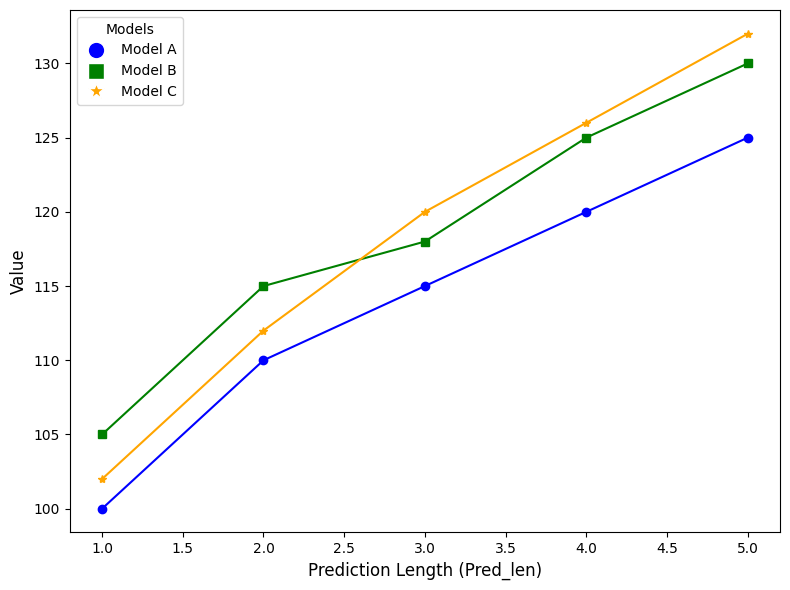

In [126]:
import matplotlib.pyplot as plt
import pandas as pd

models = ['Persistense', '(S)ARIMA']

# Create DataFrame
df = pd.DataFrame(data)

# Show the DataFrame
print(df)

# Define markers and colors for each model
models = ['Persistense', '(S)ARIMA', 'Informer', 'PatchTST']
markers = ['o', 's', '*', '^'] # , 'X'
colors = ['blue', 'green', 'orange', 'red'] # 'purple'

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each model with its line and marker
for idx, model in enumerate(models):
    subset = df[df['Model'] == model]
    ax.plot(subset['Pred_len'], subset['Value'], marker=markers[idx], color=colors[idx], label=model, linestyle='-')

# Customize legend to only show model names and corresponding markers
legend_elements = [plt.Line2D([0], [0], marker=markers[idx], color='w', markerfacecolor=colors[idx], markersize=12, label=model)
                   for model in markers]

# Add the legend to the plot
ax.legend(handles=legend_elements, title="Models", loc="best")

# Add axis labels
ax.set_xlabel('Prediction Length (Pred_len)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
